In [1]:
from loreal_poc.dataloaders.loaders import DataLoaderFFHQ
from loreal_poc.dataloaders.wrappers import FilteringDataLoader, CachedDataLoader
from loreal_poc.dataloaders.base import DataLoaderWrapper
from loreal_poc.visualisation.draw import draw_marks

from abc import abstractmethod

dl = DataLoaderFFHQ("ffhq")

In [2]:
!pip install deepface


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
from deepface import DeepFace


UNKNOWN_ETHNICITY = "unknown"


def map_deepface_ethnicity(deepface_ethnicity):
    if deepface_ethnicity == "indian":
        return "asian"
    return deepface_ethnicity


def merge_propa(ethnicity_estimate):
    propa = {}
    for k, v in ethnicity_estimate.items():
        ethnicity = map_deepface_ethnicity(k)
        if ethnicity not in propa:
            propa[ethnicity] = v
        else:
            propa[ethnicity] += v
    return propa


class WithMetaDataLoader(DataLoaderWrapper):
    def get_meta(self, idx):
        try:
            ethnicity_estimate = DeepFace.analyze(img_path=self.get_image(idx), actions=["race"])[0]["race"]
            ethnicity = merge_propa(ethnicity_estimate)

            return {"ethnicity": max(ethnicity, key=ethnicity.get)}
        except ValueError:
            # DeepFace raises a ValueError if it does not detect a face
            return {"ethnicity": UNKNOWN_ETHNICITY}

In [4]:
dl = CachedDataLoader(WithMetaDataLoader(dl), cache_size=None, cache_img=False, cache_marks=False)
dl.name

'Cached WithMetaDataLoader(ffhq)'

In [5]:
len(dl)

11

In [6]:
elt = next(dl)

In [7]:
type(elt)

tuple

In [8]:
elt[1].shape

(1, 68, 2)

In [9]:
type(elt[0])

tuple

In [10]:
type(elt[0][0])

numpy.ndarray

In [11]:
elt = next(dl)

In [12]:
asians = FilteringDataLoader(dl, lambda elt: elt[2]["ethnicity"] == "asian")
len(asians)

4

In [13]:
asians._reindex

[0, 3, 4, 7]

In [14]:
unknowns = FilteringDataLoader(dl, lambda elt: elt[2]["ethnicity"] == UNKNOWN_ETHNICITY)
len(unknowns)

3

In [15]:
unknowns._reindex

[5, 8, 9]

In [16]:
unknowns.name

"(Cached WithMetaDataLoader(ffhq)) filtered using '<lambda>'"

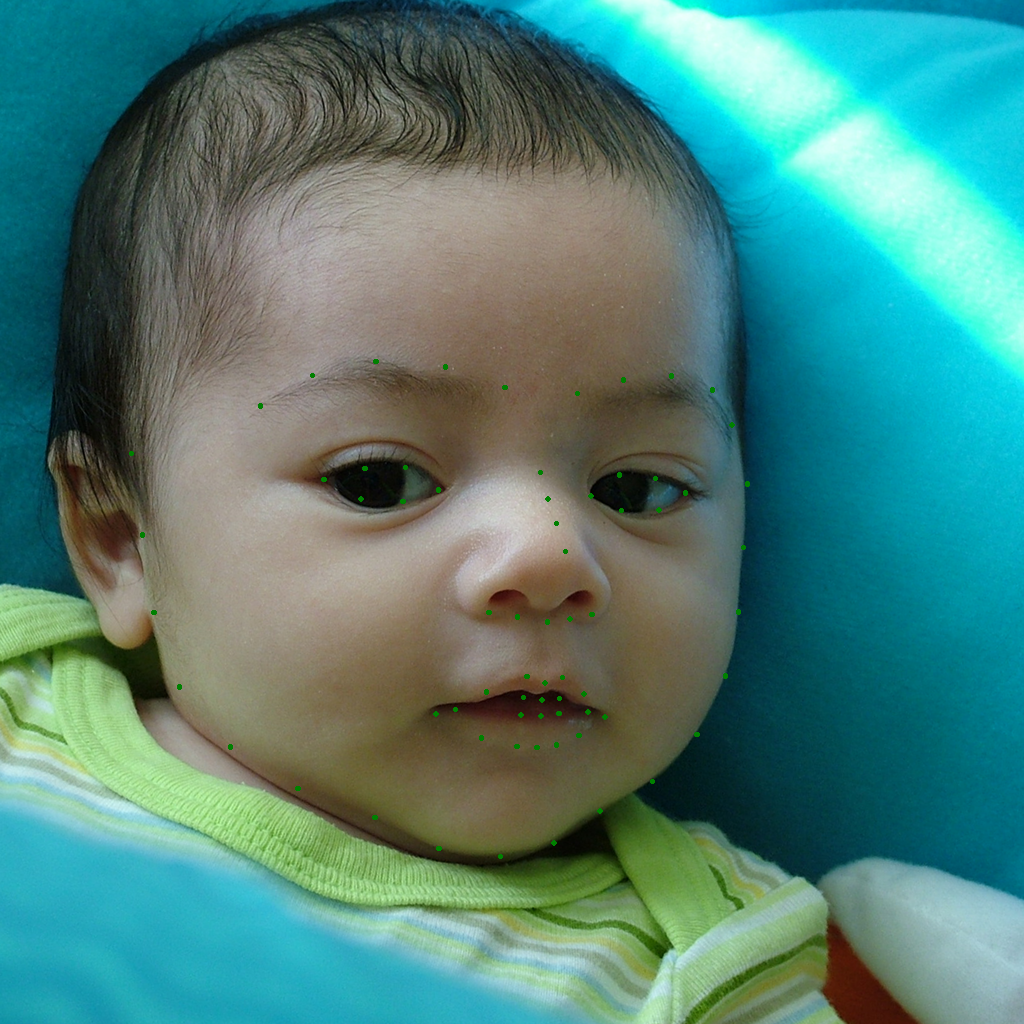

In [17]:
image, marks, meta = asians[0]
image, marks, meta = image[0], marks[0], meta[0]

draw_marks(image, [marks], ["green"])

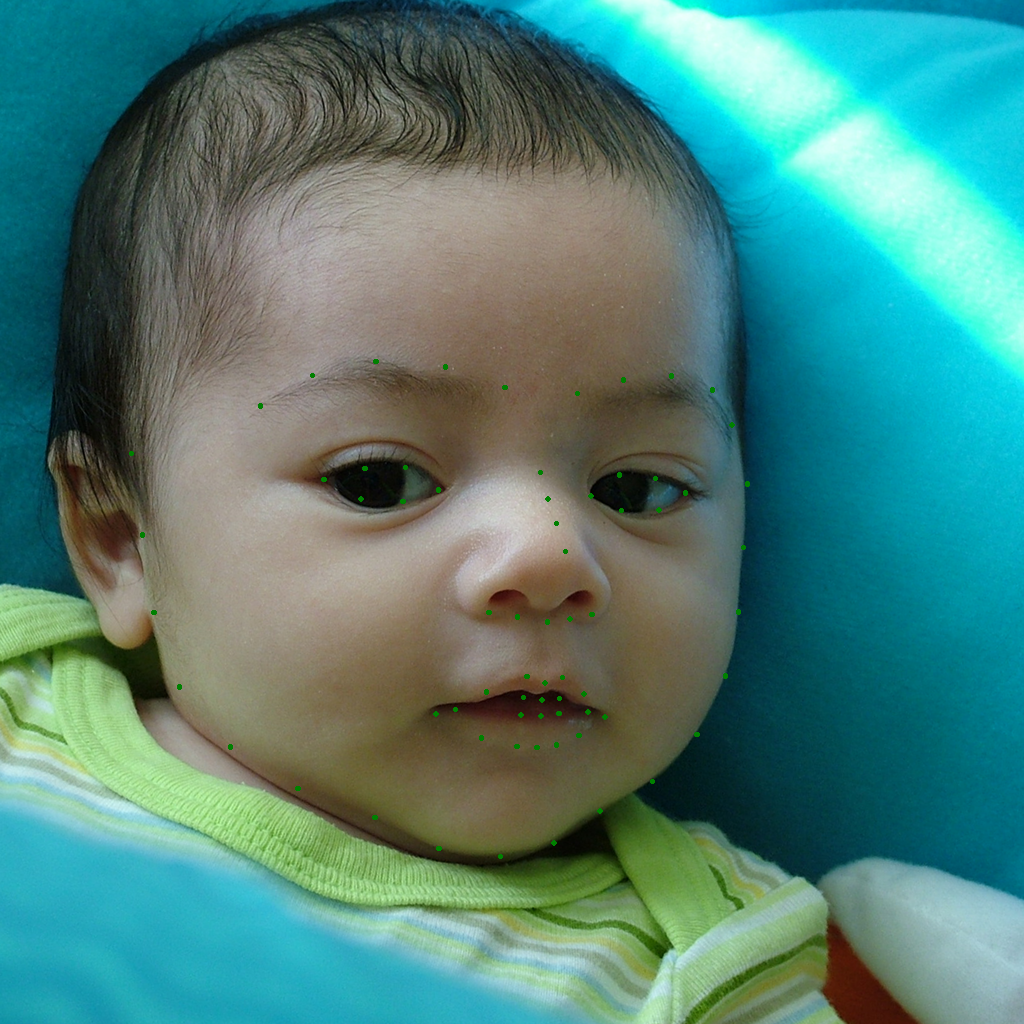

In [18]:
image, marks, meta = dl[0]
image, marks, meta = image[0], marks[0], meta[0]

draw_marks(image, [marks], ["green"])